In [1]:
import tensorflow as tf
import tensorflow.keras as K

In [2]:
# 코드 6-1 점진적 증가와 단계적 업스케일링
def upscale_layer(layer, upscale_factor):
    """
    upscale_factor(int)만큼 층(텐서)를 업스케일합니다.
    텐서 크기는 [group, height, width, channels]입니다.
    """
    height, width = layer.get_shape()[1:3]
    size = (upscale_factor * height, upscale_factor * width)
    upscaled_layer = tf.image.resize_nearest_neighbor(layer, size)
    return upscaled_layer

def smoothly_merge_last_layer(list_of_layers, alpha):
    """
    임곗값 알파를 기반으로 층을 부드럽게 합칩니다.
    이 함수는 모든 층이 이미 RGB로 바뀌었다고 가정합니다. 
    생성자를 위한 함수입니다.
    :list_of_layers    :    해상도(크기) 순서대로 정렬된 텐서 리스트
    :alpha             :    (0, 1) 사이의 실수
    """
    
    # 업스케일링을 위해 끝에서 두 번째 층을 선택합니다.
    last_fully_trained_layer = list_of_layers[-2]
    # 마지막으로 훈련된 층을 업스케일링합니다.
    last_layer_upscaled = upscale_layer(last_fully_trained_layer, 2)
    
    # 새로 추가된 층은 아직 완전히 훈련되지 않음
    larger_native_layer = list_of_layers[-1]
    
    # 합치기 전에 층 크기가 같은지 확인
    assert larger_native_layer.get_shape() == last_layer_upscaled.get_shape()
    
    # 곱셉은 브로드캐스팅되어 수행됩니다.
    new_layer = (1-alpha) * last_layer_upscaled + larger_native_layer * alpha
    
    return new_layer

In [3]:
# 코드 6-2 미니배치 표준편차
def minibatch_std_layer(layer, group_size=4):
    """
    층의 미니배치 표준편차를 계산합니다.
    층의 데이터 타입은 float32로 가정합니다. 그렇지 않으면 타입 변환이 필요합니다.
    """
    
    # 미니배치는 group_size로 나눌 수 있거나, group_size보다 같거나 작아야 합니다.
    group_size = K.backend.minimum(group_size, tf.shape(layer)[0])
    # 간단하게 쓰기 위해 크기 정보를 따로 저장합니다.
    # 그래프 실행 전에는 일반적으로 배치 차원이 None이기 때문에 tf.shape에서 이 크기를 얻습니다.
    shape = list(K.int_shape(input))
    shape[0] = tf.shape(input)[0]
    # 미니배치 수준에서 연산하기 위해 크기를 바꿈 [그룹, 미니배치, 너비, 높이, 채널]
    minibatch = K.backend.reshape(layer, (group_size, -1, shape[1], shape[2], shape[3]))
    
    # 그룹의 평균을 계산
    minibatch -= tf.reduce_mean(minibatch, axis=0, keepdims=True)
    
    # 그룹의 분산을 계산
    minibatch = tf.reduce_mean(K.backend.square(minibatch), axis=0)
    
    # 그룹의 표준편차를 계산
    minibatch = K.backend.square(minibatch + 1e-8)
    
    # 특성 맵을 평균하여 [M, 1, 1, 1]픽셀을 얻습니다.
    minibatch = tf.reduce_mean(minibatch, axis=[1, 2, 3], keepdims=True)
    
    # 스칼라 값을 그룹과 픽셀에 맞게 변환합니다.
    minibatch = K.backend.tile(minibatch,
                              [group_size, 1, shape[2], shape[3]])
    
    # 새로운 특성 맵을 추가합니다.
    return K.backend.concatenate([layer, minibatch], axis=1)

In [4]:
# 코드 6-3 균등 학습률
def equalize_learning_rate(shape, gain, fan_in=None):
    """
    He 초기화의 상수로 모든 층의 가중치를 조정하여
    특성마다 각기 다른 다이내믹 레인지를 가지도록 분산을 맞춥니다.
    shape    :    텐서(층)의 크기: 각 층의 차원입니다.
        예를 들어, [4, 4, 48, 3]. 이 경우 [커널 크기, 커널 크기, 필터 개수, 특성맵]입니다.
        하지만 구현에 따라 조금 다를 수 있습니다.
    gain     :    일반적으로 sqrt(2)
    fan_in   :    세이비어/He 초기화에서 입력 연결 개수
    """
    
    # 기본 값은 특성 맵 차원을 제외하고 shape의 모든 차원을 곱합니다.
    # 이를 통해 뉴련마다 입력 연결 개수를 얻습니다.
    if fan_in is None:
        fan_in = np.prod(shape[:-1])
    
    # He 초기화 상수
    std = gain / K.sqrt(fan_in)
    
    # 조정을 위한 상수를 만듭니다.
    wscale = K.constant(std, name="wscale", dtype=float32)
    
    # 가중치 값을 얻어 브로드캐스팅으로 wscale을 적용합니다.
    adjusted_weights = K.get_value("layer", shape=shape,
                                  initalizer=tf.initializers.random_normal()) * wscale
    
    return adjusted_weights

In [5]:
# 코드 6-4 픽셀별 특성 정규화
def pixelwize_feat_norm(input, **kwargs):
    """
    크리젭스키와 연구진이 2012년 논문에 제안한 픽셀별 특성 정규화
    :input : 케라스 / TF 층
    """
    normalization_constant = K.backend.sqrt(K.backend.mean(
                        inputs**2, axis=-1, keepdims=True) + 1.0e-8)
    return inputs / normalization_constant

## ProGAN 실행하기

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


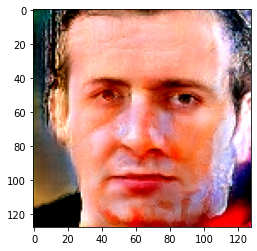

In [6]:
# 코드 6-5 TFHub 사용하기
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub

# TFHub에서 ProGAN을 임포트합니다.
module = hub.KerasLayer("https://tfhub.dev/google/progan-128/1")
# 생성할 샘플의 잠재 공간 차원
latent_dim = 512

# 시드를 바꾸면 다른 얼굴을 생성합니다.
latent_vector = tf.random.normal([1, latent_dim], seed=1337)

# 모듈을 사용해 잠재 공간에서 이미지를 생성합니다.
interpolated_images = module(latent_vector)

plt.imshow(interpolated_images.numpy().reshape(128,128,3))
plt.show()

## ProGAN 확장하기

[Chapter_6_ProGAN.ipynb (by rickiepark)](https://github.com/rickiepark/gans-in-action/blob/master/chapter-6/Chapter_6_ProGAN.ipynb)를 보고 작성

### TF-Hub 이미지 생성 모델

In [7]:
# TFHub 이미지 생성 모델
from absl import logging
import imageio
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import time
from IPython import display
from skimage import transform

# 어떤 모델을 사용할지 사전에 모른다면
# module.get_input_shape()로 이 값을 얻을 수 있습니다.
latent_dim = 512

# 0이 아니고 원점을 통과하는 직선에 놓여 있지 않은 두 벡터 사이를 보간합니다.
# 먼저 v2를 정규화하여 v1과 같은 노름을 가지도록 만듭니다.
# 그 다음 초구(hypersphere)에 있는 두 벡터 사이를 보간합니다.
def interpolate_hypersphere(v1, v2, num_steps):
    v1_norm = tf.norm(v1)
    v2_norm = tf.norm(v2)
    v2_normalized = v2 * (v1_norm / v2_norm)
    
    vectors = []
    for step in range(num_steps):
        interpolated = v1 + (v2_normalized - v1) * step / (num_steps - 1)
        interpolated_norm = tf.norm(interpolated)
        interpolater_normalized = interpolated * (v1_norm / interpolated_norm)
        vectors.append(interpolater_normalized)
    return tf.stack(vectors)

# 일련의 이미지에서 애니메이션을 만듭니다.
def animate(images):
    images = np.array(images)
    converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
    imageio.mimsave("./animation.gif", converted_images)
    with open("./animation.gif", 'rb') as f:
        display.display(display.Image(data=f.read(), height=300))
        
# 간단히 이미지를 출력합니다.
def display_image(image):
    plt.figure()
    plt.axis("off")
    plt.imshow(image)
    
# 여러 개의 이미지를 하나의 그림으로 출력합니다.
def display_images(images, captions=None):
    num_horizontally = 5
    f, axes = plt.subplots(len(images) // num_horizontally, num_horizontally, figsize=(20, 20))
    for i in range(len(images)):
        axes[i // num_horizontally, i % num_horizontally].axis("off")
        if captions is not None:
            axes[i // num_horizontally, i % num_horizontally].text(0, -3, captions[i])
        axes[i // num_horizontally, i % num_horizontally].imshow(images[i])
    f.tight_layout()
    
logging.set_verbosity(logging.ERROR)

### 잠재 공간 보간

두 개의 랜덤한 초기 벡터 사이의 잠재 공간 보간.

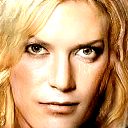

In [8]:
def interpolate_between_vectors():
    module = hub.KerasLayer("https://tfhub.dev/google/progan-128/1")

    # 다른 랜덤 벡터를 사용하려면 시드 값을 변경하세요.
    v1 = tf.random.normal([latent_dim], seed=3)
    v2 = tf.random.normal([latent_dim], seed=1)

    # v1과 v2 사이 25개의 스텝을 담은 보간 텐서를 만듭니다.
    vectors = interpolate_hypersphere(v1, v2, 25)

    # 모듈을 사용해 잠재 공간에서 이미지를 생성합니다.
    interpolated_images = module(vectors)

    animate(interpolated_images)

interpolate_between_vectors()

### 잠재 공간에서 가장 가까운 벡터 찾기

타깃 이미지를 고정하기 위해 모듈이 생성한 이미지를 업로드하여 사용

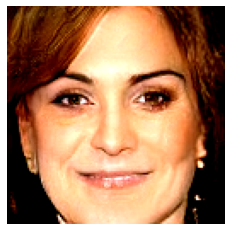

In [9]:
image_from_module_space = True

def get_module_space_image():
    module = hub.KerasLayer("https://tfhub.dev/google/progan-128/1")
    vector = tf.random.normal([1, latent_dim], seed=4)
    images = module(vector)
    return images[0]

def upload_image():
    uploaded = files.upload()
    image = imageio.imread(uploaded[uploaded.keys()[0]])
    return transform.resize(image, [128, 128])

if image_from_module_space:
    target_image = get_module_space_image()
else:
    target_image = upload_image()
display_image(target_image)

In [10]:
def find_closet_latent_vector(num_optimization_steps, steps_per_image):
    images = []
    losses = []
    module = hub.KerasLayer("https://tfhub.dev/google/progan-128/1")
    
    initial_vector = tf.random.normal([1, latent_dim], seed = 5)
    
    vector = tf.Variable(initial_vector)
    optimizer = tf.optimizers.Adam(learning_rate=0.01)
    loss_fn = tf.losses.MeanAbsoluteError(reduction="sum")
    
    for step in range(num_optimization_steps):
        if (step % 100) == 0:
            print()
        print(".", end="")
        with tf.GradientTape() as tape:
            image = module(vector.read_value())
            if (step % steps_per_image) == 0:
                images.append(image.numpy().reshape(128, 128, 3))
            target_image_difference = loss_fn(image, target_image[:, :, :3])
            """
            잠재 벡터는 정규 분포에서 샘플링했습니다.
            잠재 벡터의 길이를 이 분포에서 얻은 벡터의 평균 길이로 제한하면
            더 실제 같은 이미지를 얻을 수 있습니다.
            """
            regulizer = tf.abs(tf.norm(vector) - np.sqrt(latent_dim))
            
            loss = target_image_difference + regulizer
            losses.append(loss.numpy())
        grads = tape.gradient(loss, [vector])
        optimizer.apply_gradients(zip(grads, [vector]))
        
    return images, losses

result = find_closet_latent_vector(num_optimization_steps=200, steps_per_image=5)


....................................................................................................
....................................................................................................

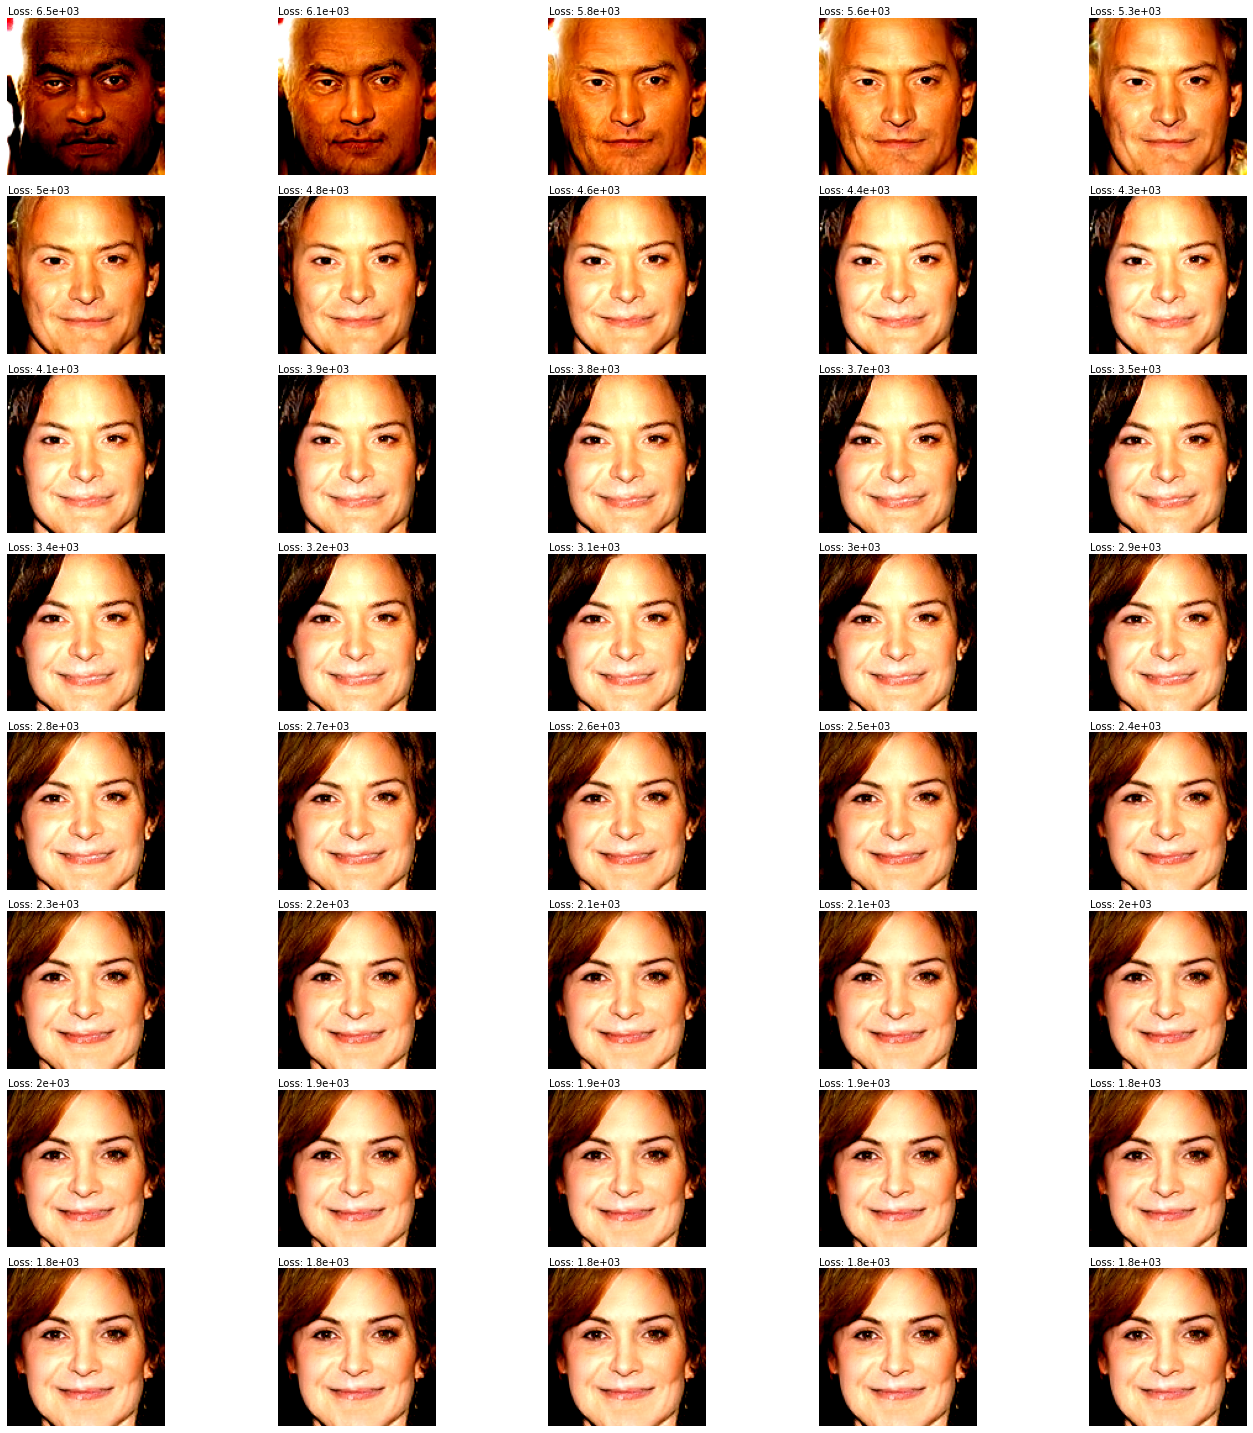

In [11]:
captions = [f"Loss: {l:.2}" for  l in result[1]]
display_images(result[0], captions)